In [109]:
import numpy as np
from ase import Atoms, units
from ase.calculators.lj import LennardJones
from ase.optimize import BFGS
from ase.constraints import FixedPlane
from ase.visualize import view

from math import sqrt, exp
import matplotlib.pyplot as plt

from math import sqrt, exp
import matplotlib.pyplot as plt
from numpy.random import default_rng

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import ShuffleSplit

# a random number generator
rng = np.random.default_rng(19884)
ljcalc = LennardJones()

# Task 1: Fitting the initial NN

In [110]:
#Define MLPRegressor
nn = MLPRegressor(hidden_layer_sizes=(10, 10), activation='logistic', solver='lbfgs', max_iter=50000)

In [113]:
# utility Functions
def plot_vs_energy(y_true, y_predict, T, r2, mae, mse, type_data):
    """ Plots Predicted energy vs actual energy for input data
    
    Parameters
    ----------
    y_true: 1-d ndarray
            Actual energy
    y_predict: 1-d ndarray
               prediction energy
    T : int
        Temprature 
    r2: float
        r2_score value
    mae : float
          MAE value
    mse : float
          MSE value
    type_data: string
               type of data set to be plotted.
               Train/ Test/ Total
    """
    x_min = np.min(np.concatenate((y_true, y_predict)))
    x_max = np.max(np.concatenate((y_true, y_predict)))
    line = np.linspace(x_min, x_max, 10)
    plt.plot(line, line,  c='r')

    ax = plt.subplot(1,1,1)
    ax.set_xlim([x_min, x_max])
    ax.set_ylim([x_min, x_max])
    ax.scatter(y_predict, y_true, marker='.', c='g')
    plt.xlabel('Actual energy (eV)')
    plt.ylabel('predicted energy (eV) ')
    plt.title(f'T = {T} K {type_data} \n prediction vs actual values \n r2_score :{r2:5.4f}, MAE score: {mae:5.4f}, MSE score: {mse:5.4f}')
    plt.show()

#### Fitting of NN for 3D , T =800K dataset 

In [114]:
# Load the dataset
with open('3d_800.npy', 'rb') as f:
    X3d_800 = np.load(f)
    y3d_800 = np.load(f)
    
# Split the dataset 
rs = ShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

for train, test in rs.split(X3d_800):
    train = train
    test = test

nn.fit(X3d_800[train], y3d_800[train])
y_pred = nn.predict(X3d_800)

r2 score : 0.9966



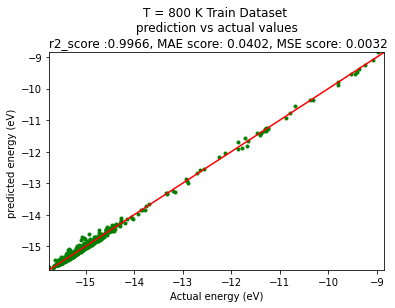

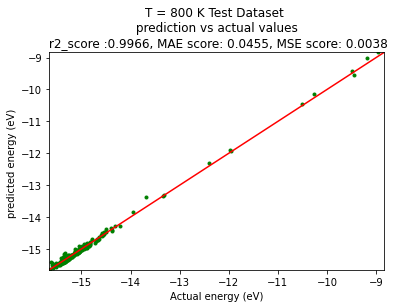

In [116]:
# evaluation
r2 = r2_score(y3d_800[test], y_pred[test])

mae_tr = mean_absolute_error(y3d_800[train], y_pred[train])
mae_test = mean_absolute_error(y3d_800[test], y_pred[test])

mse_tr = mean_squared_error(y3d_800[train], y_pred[train])
mse_test = mean_squared_error(y3d_800[test], y_pred[test])

print(f'r2 score : {r2:5.4f}\n') 
#print(f'MAE train: {mae_tr:5.4f} , MAE test: {mae_test:5.4f}')
#print(f'MSE train: {mse_tr:5.4f} , MSE test: {mse_test:5.4f}')

plot_vs_energy(y3d_800[train], y_pred[train], 800, r2, mae_tr, mse_tr, 'Train Dataset')
plot_vs_energy(y3d_800[test], y_pred[test], 800, r2, mae_test, mse_test, 'Test Dataset')

## 2.2 : Task 2. MC step function using the NN

In [120]:
def mcstep_NN(nn, config, T, sigma_G, dim, rng):
    """
    compute a single step with Metropolis-hasting algorithm for an 
    given ase atom object
    
    Parameters
    ----------
    nn_mlpReg : MLPRegressor object
         
    config : Ase atom object
    
    T : float
        Temperature of the simulation (kelvin)
    sigma_G : float
              Magnitude of displacment in a single MC step using
              standard deviation of a normal distribution
    dim : int
          Dimension of the system in which simulation is being carried
          
    Returns
    -------
    config : Atoms object
             Accepted new configuration of atoms after single accepted MC move
                  
    Raises
    --------
    ValueError
        if 'T' is less than 0 
        
    ValueError
        if 'dim' is negative or zero
    
    """
    if T < 0:
        raise ValueError("T should be non-negative")
        
    if dim <= 0:
        raise ValueError("Invalid dimension of system; should be positive ")
    
    #initilisation of configuration
    pos_old = config.get_positions()
    
    # descriptor
    des =  np.trim_zeros(np.sort(np.ravel(config.get_all_distances())))[::2]
    e_old = nn.predict(des.reshape(1, -1)) #(1 rows, 21 column)
    
    # adding normal random displacement with zero-mean and sigma std
    rand_disp = np.random.normal(0, sigma_G, size=pos_old.shape)
    if dim == 2:        # for 2 dimesional atoms object (xy plane)
        rand_disp[:, 2] = 0.0
    pos_new = pos_old + rand_disp
    
    #descriptor evaluation
    config.set_positions(pos_new)
    des = np.trim_zeros(np.sort(np.ravel(config.get_all_distances())))[::2]
    e_new = nn.predict(des.reshape(1, -1))
    
    #detailed balance condition
    dE = (e_new - e_old)
    detailed_condition = np.exp(-dE/(units.kB*T))
    
    #acccept or reject 
    p_acc = detailed_condition if detailed_condition <1 else 1
    
    alpha = rng.uniform()  # a number from uniform distr (0,1]
    if alpha < p_acc:
        config.set_positions(pos_new) # accept
        return config, 1, e_new[0], 
    else:
        config.set_positions(pos_old) #reject
        return config, 0, e_old[0]

## 2.3:  Task 3:  MC sampling  using the NN potential for 3D cluster at T = 800 K 

In [122]:
#load the optimised .xyz file of cluster 3D at 800 K
from ase.io import read, write
cluster_3D = read('cluster_3D_opt.xyz')
orig_pos = cluster_3D.get_positions()

In [123]:
#attach calculater to Atom object (cluster_3D)
cluster_3D.calc = ljcalc
# set number of MC steps
mcsteps = 30001
# how often to collect energy
ncollect = 2000
#lists to store energies
energy_nn = []
energy_lj = []

# MC sampling to create a set of configurations using NN potential
for i in range(mcsteps):
    #mcstep with NN potential
    cluster_3D, acc, step_energy = mcstep_NN(nn, cluster_3D, T=800, sigma_G=0.01, dim=3, rng=rng)
    step_lj_energy = cluster_3D.get_potential_energy()
    #save the calculated energy
    if (i % nprint) == 0:
        energy_nn.append(step_energy)
        energy_lj.append(step_lj_energy)

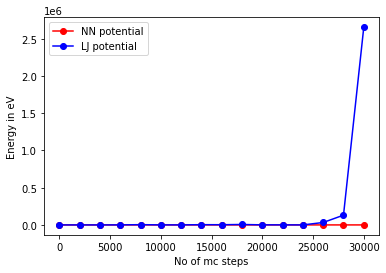

In [125]:
x_axis = np.arange(len(energy_nn)) * 2000
plt.plot(x_axis, energy_nn, color='r', label='NN potential', marker='o')
plt.plot(x_axis, energy_lj, color='b', label='LJ potential', marker='o')
plt.xlabel('No of mc steps')
plt.ylabel('Energy in eV')
plt.legend()
plt.show()

The above results shows that some of NN potentials are not suitable for MC sampling since their NN potential and LJ potential differ very much.

## 2.4: Task 4: Refitting the NN potential

#### Additional data creation with NN potential sampling

In [126]:
#set cluster to initial configuration
cluster_3D.set_positions(orig_pos)
# set number of MC steps
mcsteps = 30001
# how often to collect energy
ncollect = 20
#lists to store additional configurations and energies
X3d_additional = []
y3d_additional = []

for i in range(mcsteps):
    cluster_3D, acc, step_energy = mcstep_NN(nn, cluster_3D, T=800, sigma_G=0.01, dim=3, rng=rng)
    step_lj_energy = cluster_3D.get_potential_energy()
    # modifiled MC sampling with non-positive LJ energy configuration
    if (i % ncollect) == 0:
        if step_lj_energy < 0:
            dist = cluster_3D.get_all_distances()
            dist = np.trim_zeros(np.sort(np.ravel(dist)))
            X3d_additional.append(dist[::2])
            y3d_additional.append(step_lj_energy)

**How many additional data is created**

In [127]:
len(X3d_additional)

225

####  fitting of NN with additional data and evaluation

In [128]:
# fitting of NN with additional data
X3d_additional = np.array(X3d_additional)
y3d_additional = np.array(y3d_additional)

X3d_extended = np.concatenate((X3d_800, X3d_additional), axis =0)
y3d_extended = np.concatenate((y3d_800, y3d_additional), axis =0)

for train, test in rs.split(X3d_extended):
    train = train
    test = test
    
nn.fit(X3d_extended[train], y3d_extended[train])
y3d_ext_pred = nn.predict(X3d_extended)

r2_ = r2_score(y3d_extended[test], y3d_ext_pred[test])

mae_tr = mean_absolute_error(y3d_extended[train], y3d_ext_pred[train])
mae_test = mean_absolute_error(y3d_extended[test], y3d_ext_pred[test])

mse_tr = mean_squared_error(y3d_extended[train], y3d_ext_pred[train])
mse_test = mean_squared_error(y3d_extended[test], y3d_ext_pred[test])

print(f'r2 score : {r2:5.4f}') 
print(f'MAE train: {mae_tr:5.4f} , MAE test: {mae_test:5.4f}')
print(f'MSE train: {mse_tr:5.4f} , MSE test: {mse_test:5.4f}')

r2 score : 0.9966
MAE train: 0.3948 , MAE test: 0.3501
MSE train: 1.4293 , MSE test: 0.9206


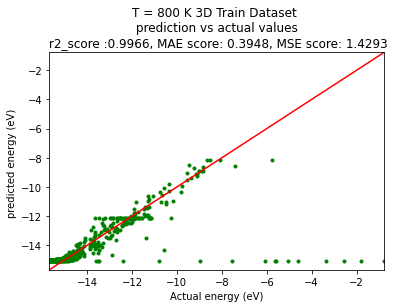

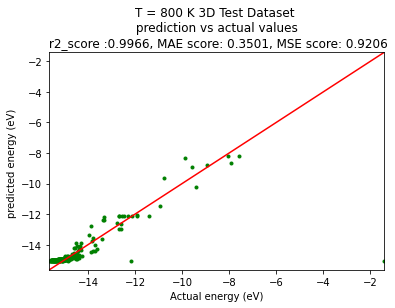

In [129]:
plot_vs_energy(y3d_ext_pred[train], y3d_extended[train], 800, r2, mae_tr, mse_tr, '3D Train Dataset')
plot_vs_energy(y3d_ext_pred[test], y3d_extended[test], 800, r2, mae_test, mse_test, '3D Test Dataset')

#### Perform the MC sampling using fitted NN with extended dataset to check the quality of MC sampling with extended dataset

In [130]:
cluster_3D.set_positions(orig_pos)

# set number of MC steps
mcsteps = 30001
# how often to collect energy
ncollect = 2000
energy_nn = []
energy_lj = []

# MC sampling
for i in range(mcsteps):
    
    cluster_3D, acc, step_energy = mcstep_NN(nn, cluster_3D, T=800, sigma_G=0.01, dim=3, rng=rng)
    step_lj_energy = cluster_3D.get_potential_energy()
    
    if (i % ncollect) == 0:
        #print(i,step_energy, step_lj_energy)
        energy_nn.append(step_energy)
        energy_lj.append(step_lj_energy)

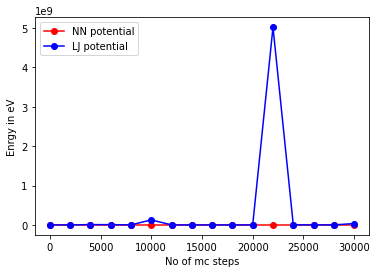

In [131]:
x_axis = np.arange(len(energy_nn)) * 2000
plt.plot(x_axis, energy_nn, color='r', label='NN potential', marker='o')
plt.plot(x_axis, energy_lj, color='b', label='LJ potential', marker='o')
plt.xlabel('No of mc steps')
plt.ylabel('Enrgy in eV')
plt.legend()
plt.show()

The MC sampling seems to be not improved after addition of  sampled configurations with NN potential

### Second round of extending the dataset

In [132]:
cluster_3D.set_positions(orig_pos)
# set number of MC steps
mcsteps = 30001
# how often to collect configuration and energy
ncollect = 20

X3d_additional = []
y3d_additional = []

# do a simple MC sampling to create a set of configurations
for i in range(mcsteps):
    
    cluster_3D, acc, step_energy = mcstep_NN(nn, cluster_3D, T=800, sigma_G=0.01, dim=3, rng=rng)
    step_lj_energy = cluster_3D.get_potential_energy()
        
    if (i % ncollect) == 0:
        if step_lj_energy < 0:
            dist = cluster_3D.get_all_distances()
            dist = np.trim_zeros(np.sort(np.ravel(dist)))
            X3d_additional.append(dist[::2])
            y3d_additional.append(step_lj_energy)

In [133]:
#### fitting with extended dataset
X3d_additional = np.array(X3d_additional)
y3d_additional = np.array(y3d_additional)

X3d_extended = np.concatenate((X3d_extended, X3d_additional), axis =0)
y3d_extended = np.concatenate((y3d_extended, y3d_additional), axis =0)


for train, test in rs.split(X3d_extended):
    train = train
    test = test
    
nn.fit(X3d_extended[train], y3d_extended[train])
y3d_ext_pred = nn.predict(X3d_extended)

r2_ = r2_score(y3d_extended[test], y3d_ext_pred[test])

mae_tr = mean_absolute_error(y3d_extended[train], y3d_ext_pred[train])
mae_test = mean_absolute_error(y3d_extended[test], y3d_ext_pred[test])

mse_tr = mean_squared_error(y3d_extended[train], y3d_ext_pred[train])
mse_test = mean_squared_error(y3d_extended[test], y3d_ext_pred[test])

print(f'r2 score : {r2:5.4f}') 
print(f'MAE train: {mae_tr:5.4f} , MAE test: {mae_test:5.4f}')
print(f'MSE train: {mse_tr:5.4f} , MSE test: {mse_test:5.4f}')

r2 score : 0.9966
MAE train: 0.5571 , MAE test: 0.6350
MSE train: 0.7609 , MSE test: 1.1292


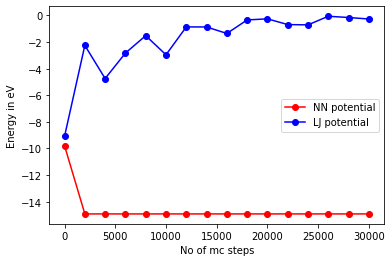

In [134]:
# MC sampling with fitted NN
cluster_3D.set_positions(orig_pos)

# set number of MC steps
mcsteps = 30001
# how often to collect energy
ncollect = 2000
energy_nn = []
energy_lj = []

# MC sampling to create a set of configurations using NN potential
for i in range(mcsteps):
    
    cluster_3D, acc, step_energy = mcstep_NN(nn, cluster_3D, T=800, sigma_G=0.01, dim=3, rng=rng)
    step_lj_energy = cluster_3D.get_potential_energy()
    
    if (i % ncollect) == 0:
        #print(i,step_energy, step_lj_energy)
        energy_nn.append(step_energy)
        energy_lj.append(step_lj_energy)

x_axis = np.arange(len(energy_nn)) * 2000
plt.plot(x_axis, energy_nn, color='r', label='NN potential', marker='o')
plt.plot(x_axis, energy_lj, color='b', label='LJ potential', marker='o')
plt.xlabel('No of mc steps')
plt.ylabel('Energy in eV')
plt.legend()
plt.show()

It seems that the mc sampling gets better becasue we do not get very high energy values but the difference is still  significant.

# 3. Transferability of the NN potential

# 3.1 Task 1: low and high temprature data 

In [136]:
# Load the dataset 
with open('3d_10.npy', 'rb') as f:
    X3d_10 = np.load(f)
    y3d_10 = np.load(f)

In [137]:
# Split the dataset 
rs = ShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

for train, test in rs.split(X3d_10):
    train = train
    test = test

In [138]:
nn = MLPRegressor(hidden_layer_sizes=(10, 10), activation='logistic', solver='lbfgs', max_iter=50000)
nn.fit(X3d_10[train], y3d_10[train])
y_pred = nn.predict(X3d_10)

# evaluation
r2 = r2_score(y3d_10[test], y_pred[test])

mae_tr = mean_absolute_error(y3d_10[train], y_pred[train])
mae_test = mean_absolute_error(y3d_10[test], y_pred[test])

mse_tr = mean_squared_error(y3d_10[train], y_pred[train])
mse_test = mean_squared_error(y3d_10[test], y_pred[test])

print(f'r2 score : {r2:5.4f}') 
print(f'MAE train: {mae_tr:5.4f} , MAE test: {mae_test:5.4f}')
print(f'MSE train: {mse_tr:5.4f} , MSE test: {mse_test:5.4f}')

r2 score : 0.9997
MAE train: 0.0199 , MAE test: 0.0231
MSE train: 0.0008 , MSE test: 0.0011


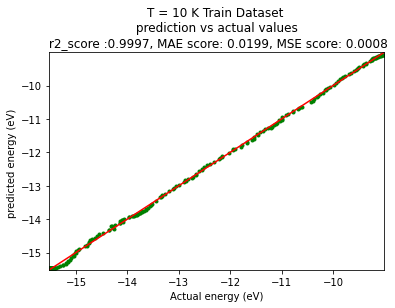

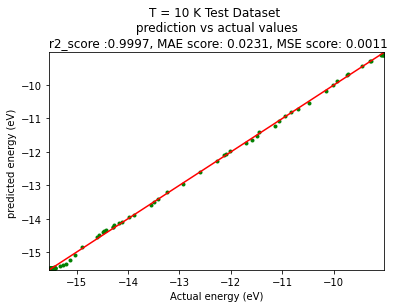

In [140]:
plot_vs_energy(y3d_10[train], y_pred[train], 10, r2, mae_tr, mse_tr, 'Train Dataset')
plot_vs_energy(y3d_10[test], y_pred[test], 10, r2, mae_test, mse_test, 'Test Dataset')

#### Check transferbilty to 800 K

In [141]:
# Load the dataset
with open('3d_800.npy', 'rb') as f:
    X3d_800 = np.load(f)
    y3d_800 = np.load(f)
    
y_pred_800 = nn.predict(X3d_800)

In [142]:
# evaluation
r2 = r2_score(y3d_800, y_pred_800)
mae = mean_absolute_error(y3d_800, y_pred_800)
mse = mean_squared_error(y3d_800, y_pred_800)

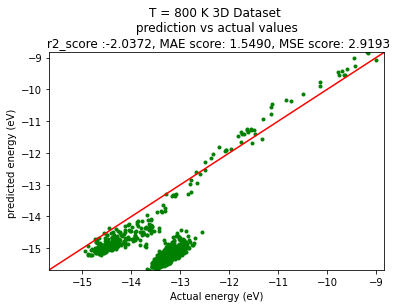

In [144]:
plot_vs_energy(y3d_800, y_pred_800, 800, r2, mae, mse, '3D Dataset')

The $r^2$ score is negative and the points have a large variance from Y=X line. So its not transferable for higher tempratures.

# 3.2  Task 2: fitting the mixed dataset

Dataset created with  
$\sigma$ = 0.0022  at T = 50 gives acceptance ratio =0.496  
$\sigma$ = 0.0043  at T = 200 gives acceptance ratio =0.502  
$\sigma$ = 0.00677  at T = 500 gives acceptance ratio =0.509  


In [145]:
# Load the datasets
with open('3d_10.npy', 'rb') as f:
    X3d_10 = np.load(f)
    y3d_10 = np.load(f)

with open('3d_50.npy', 'rb') as f:
    X3d_50 = np.load(f)
    y3d_50 = np.load(f)

with open('3d_200.npy', 'rb') as f:
    X3d_200 = np.load(f)
    y3d_200 = np.load(f)

with open('3d_500.npy', 'rb') as f:
    X3d_500 = np.load(f)
    y3d_500 = np.load(f)
    
with open('3d_800.npy', 'rb') as f:
    X3d_800 = np.load(f)
    y3d_800 = np.load(f)

In [146]:
# combine dataset at T = 10, 50, 500, 800
X_comb = np.concatenate((X3d_10, X3d_50, X3d_500, X3d_800), axis =0)
y_comb = np.concatenate((y3d_10, y3d_50, y3d_500, y3d_800), axis =0)

In [147]:
# Split the dataset 
rs = ShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

for train, test in rs.split(X_comb):
    train = train
    test = test

nn = MLPRegressor(hidden_layer_sizes=(10, 10), activation='logistic', solver='lbfgs', max_iter=50000)
nn.fit(X_comb[train], y_comb[train])
y_pred_comb = nn.predict(X_comb)

# evaluation
r2 = r2_score(y_comb[test], y_pred_comb[test])

mae_tr = mean_absolute_error(y_comb[train], y_pred_comb[train])
mae_test = mean_absolute_error(y_comb[test], y_pred_comb[test])

mse_tr = mean_squared_error(y_comb[train], y_pred_comb[train])
mse_test = mean_squared_error(y_comb[test], y_pred_comb[test])

print(f'r2 score : {r2:5.4f}') 
print(f'MAE train: {mae_tr:5.4f} , MAE test: {mae_test:5.4f}')
print(f'MSE train: {mse_tr:5.4f} , MSE test: {mse_test:5.4f}')

r2 score : 0.9988
MAE train: 0.0360 , MAE test: 0.0359
MSE train: 0.0025 , MSE test: 0.0024


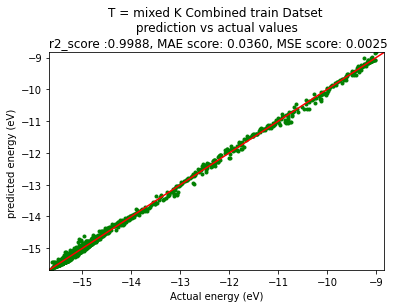

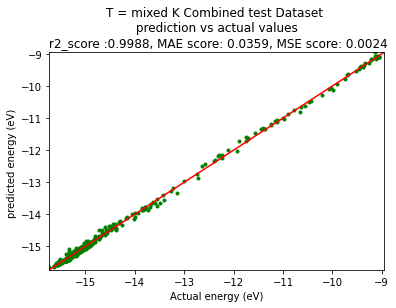

In [148]:
plot_vs_energy(y_comb[train], y_pred_comb[train], 'mixed', r2, mae_tr, mse_tr, 'Combined train Datset')
plot_vs_energy(y_comb[test], y_pred_comb[test], 'mixed', r2, mae_test, mse_test, 'Combined test Dataset')

#### Prediction for T = 200 (transferablity check)

In [149]:
# Load the dataset
with open('3d_200.npy', 'rb') as f:
    X3d_200 = np.load(f)
    y3d_200 = np.load(f)

In [150]:
# Prediction for T = 200
y_pred_200 = nn.predict(X3d_200)
# evaluation
r2 = r2_score(y3d_200, y_pred_200)

mae = mean_absolute_error(y3d_200, y_pred_200)
mse = mean_squared_error(y3d_200, y_pred_200)

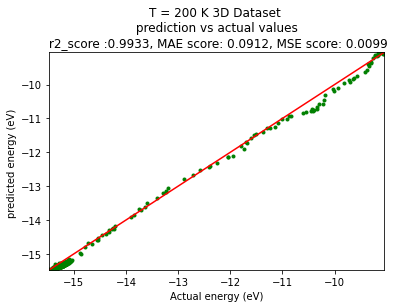

In [151]:
plot_vs_energy(y3d_200, y_pred_200, 200, r2, mae, mse, '3D Dataset')

The above plot shows our network fitted with combined dataset works well for unseen Temprature T = 200 K data which shows our network is showing transferability. Small MSE and high $R^2$ score.

## 3.3 Task 3 Transferability from 3d to 2D

In [152]:
# combine all datasets:
X_comb = np.concatenate((X3d_10, X3d_50, X3d_200, X3d_500, X3d_800), axis =0)
y_comb = np.concatenate((y3d_10, y3d_50, y3d_200, y3d_500, y3d_800), axis =0)

In [153]:
# Split the dataset 
rs = ShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

for train, test in rs.split(X_comb):
    train = train
    test = test

nn = MLPRegressor(hidden_layer_sizes=(10, 10), activation='logistic', solver='lbfgs', max_iter=50000)
nn.fit(X_comb[train], y_comb[train])
y_pred_comb = nn.predict(X_comb)

# evaluation
r2 = r2_score(y_comb[test], y_pred_comb[test])

mae_tr = mean_absolute_error(y_comb[train], y_pred_comb[train])
mae_test = mean_absolute_error(y_comb[test], y_pred_comb[test])

mse_tr = mean_squared_error(y_comb[train], y_pred_comb[train])
mse_test = mean_squared_error(y_comb[test], y_pred_comb[test])

print(f'r2 score : {r2:5.4f}') 
print(f'MAE train: {mae_tr:5.4f} , MAE test: {mae_test:5.4f}')
print(f'MSE train: {mse_tr:5.4f} , MSE test: {mse_test:5.4f}')

r2 score : 0.9991
MAE train: 0.0262 , MAE test: 0.0272
MSE train: 0.0018 , MSE test: 0.0019


#### MAE, MSE and square plot for combined 3d datsets

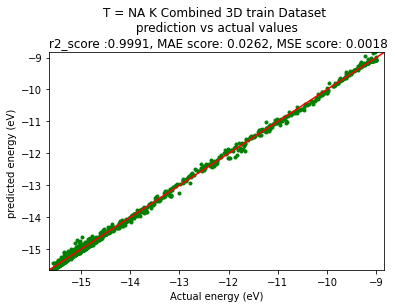

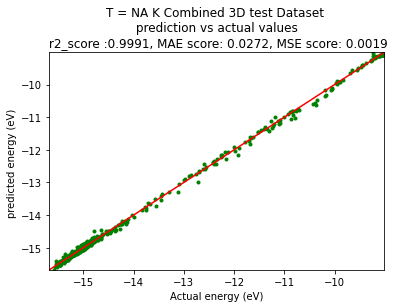

In [155]:
plot_vs_energy(y_comb[train], y_pred_comb[train], 'NA', r2, mae_tr, mse_tr, 'Combined 3D train Dataset')
plot_vs_energy(y_comb[test], y_pred_comb[test], 'NA', r2, mae_test, mse_test, 'Combined 3D test Dataset')

####  Prediction of 2d cluster for combined 3d dataset fitted NN

In [156]:
# Load the datasets
with open('2d_200.npy', 'rb') as f:
    X2d_200 = np.load(f)
    y2d_200 = np.load(f)
    
with open('2d_2000.npy', 'rb') as f:
    X2d_2000 = np.load(f)
    y2d_2000 = np.load(f)

#### Prediction for T = 200 for 2D

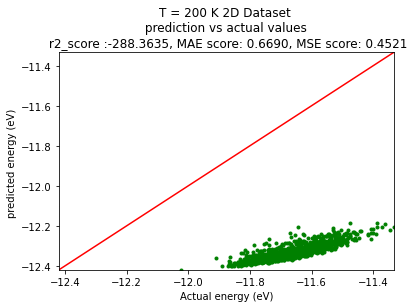

In [157]:
# Prediction for T = 200 for 2D
y2d_pred_200 = nn.predict(X2d_200)

# evaluation
r2 = r2_score(y2d_200, y2d_pred_200)
mae = mean_absolute_error(y2d_200, y2d_pred_200)
mse = mean_squared_error(y2d_200, y2d_pred_200)

plot_vs_energy(y2d_200, y2d_pred_200, 200, r2, mae, mse, '2D Dataset')

##### Prediction for T = 2000 for 2D

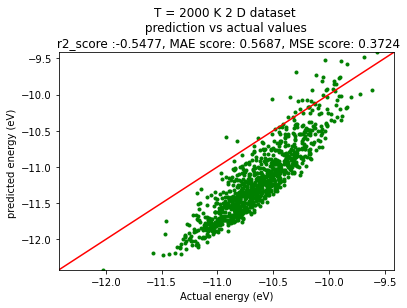

In [158]:
# Prediction for T = 2000 for 2D
y2d_pred_2000 = nn.predict(X2d_2000)
# evaluation
r2 = r2_score(y2d_2000, y2d_pred_2000)

mae = mean_absolute_error(y2d_2000, y2d_pred_2000)
mse = mean_squared_error(y2d_2000, y2d_pred_2000)

plot_vs_energy(y2d_2000, y2d_pred_2000, 2000, r2, mae, mse, '2 D dataset')

The NN trained by combining all 3D cluster data is not transferable T= 200k, 2D clusters case  and shows some improvemment in transferabilty for 2000k. but overall it does not do a good prediction for 2D cluster.

## 3.4 Task 4: including all datasets

In [159]:
# Load the datasets
with open('3d_10.npy', 'rb') as f:
    X3d_10 = np.load(f)
    y3d_10 = np.load(f)

with open('3d_50.npy', 'rb') as f:
    X3d_50 = np.load(f)
    y3d_50 = np.load(f)

with open('3d_200.npy', 'rb') as f:
    X3d_200 = np.load(f)
    y3d_200 = np.load(f)

with open('3d_500.npy', 'rb') as f:
    X3d_500 = np.load(f)
    y3d_500 = np.load(f)
    
with open('3d_800.npy', 'rb') as f:
    X3d_800 = np.load(f)
    y3d_800 = np.load(f)
    
with open('2d_200.npy', 'rb') as f:
    X2d_200 = np.load(f)
    y2d_200 = np.load(f)
    
with open('2d_2000.npy', 'rb') as f:
    X2d_2000 = np.load(f)
    y2d_2000 = np.load(f)

In [160]:
# combine all datasets:
X_comb = np.concatenate((X3d_10, X3d_50, X3d_200, X3d_500, X3d_800, X2d_200, X2d_2000 ), axis =0)
y_comb = np.concatenate((y3d_10, y3d_50, y3d_200, y3d_500, y3d_800, y2d_200, y2d_2000), axis =0)

In [161]:
# Split the dataset 
rs = ShuffleSplit(n_splits=1, test_size=0.2, random_state=1)

for train, test in rs.split(X_comb):
    train = train
    test = test

nn = MLPRegressor(hidden_layer_sizes=(10, 10), activation='logistic', solver='lbfgs', max_iter=50000)
nn.fit(X_comb[train], y_comb[train])
y_pred_comb = nn.predict(X_comb)

# evaluation
r2 = r2_score(y_comb[test], y_pred_comb[test])

mae_tr = mean_absolute_error(y_comb[train], y_pred_comb[train])
mae_test = mean_absolute_error(y_comb[test], y_pred_comb[test])

mse_tr = mean_squared_error(y_comb[train], y_pred_comb[train])
mse_test = mean_squared_error(y_comb[test], y_pred_comb[test])

print(f'r2 score : {r2:5.4f}') 

r2 score : 0.9985


#### MSE, MAE and square plot for training and test set of combined data

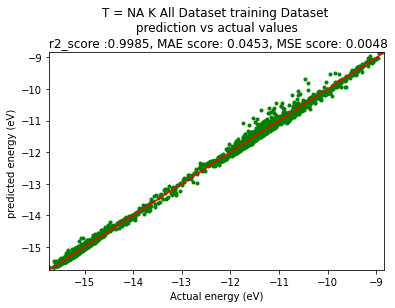

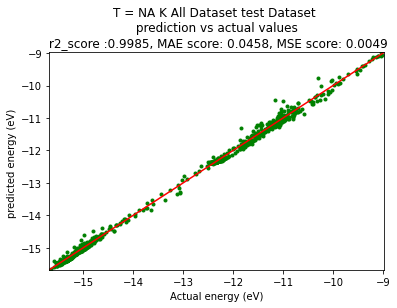

In [162]:
plot_vs_energy(y_comb[train], y_pred_comb[train], 'NA', r2, mae_tr, mse_tr, 'All Dataset training Dataset')
plot_vs_energy(y_comb[test], y_pred_comb[test], 'NA', r2, mae_test, mse_test, 'All Dataset test Dataset')

#### MSE, MAE and square plot for 2D and T = 200

r2 score : -0.1542
 


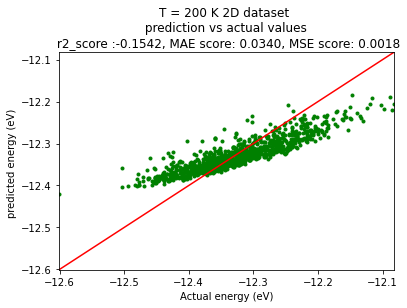

In [163]:
# Prediction for T = 200 for 2D
y2d_pred_200 = nn.predict(X2d_200)
# evaluation
r2 = r2_score(y2d_200, y2d_pred_200)

mae = mean_absolute_error(y2d_200, y2d_pred_200)
mse = mean_squared_error(y2d_200, y2d_pred_200)

print(f'r2 score : {r2:5.4f}\n ') 
plot_vs_energy(y2d_200, y2d_pred_200, 200, r2, mae, mse, '2D dataset')

#### MSE, MAE and square plot for 2D and T = 2000

r2 score : 0.9205



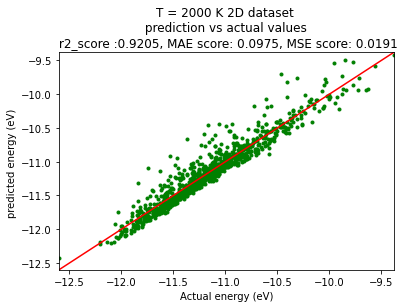

In [164]:
# Prediction for T = 2000 for 2D
y2d_pred_2000 = nn.predict(X2d_2000)
# evaluation
r2 = r2_score(y2d_2000, y2d_pred_2000)

mae = mean_absolute_error(y2d_2000, y2d_pred_2000)
mse = mean_squared_error(y2d_2000, y2d_pred_2000)

print(f'r2 score : {r2:5.4f}\n') 
plot_vs_energy(y2d_2000, y2d_pred_2000, 2000, r2, mae, mse, '2D dataset')

For 2000k, the network does a good job but for T=200k, it does not predict well.